# Superstore Churn 1.03: Feature Engineering

**Version 1.03**

by Linh Toan

[Data Science @ Newman University](https://newmanu.edu/academics/graduate-programs/ms-data-science)

# Import Libraries and Set Notebook Defaults

In [1]:
# Numpy and Pandas
import numpy as np
import pandas as pd

# Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from numpy import linalg
from scipy.linalg import svd

In [2]:
# Jupyter Notebook customizations

# Remove scientific notation from descriptive stats
pd.options.display.float_format = '{:,.3f}'.format

# Display all columns of a dataframe
pd.set_option('display.max_columns', None)

# Widen columns
pd.set_option('display.max_colwidth', 150)

In [3]:
# Customize Seaborn Plot Styles

# Adjust to retina quality
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# Adjust dpi and font size to support high-pixel-density screens
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook', font_scale = 0.8)

# Display tick marks
sns.set_style('ticks')

# Remove borders
plt.rc('axes.spines', top=False, right=False, left=False, bottom=False)

# Set color palettes for plots
# See Matplotlib named color options here: https://matplotlib.org/stable/gallery/color/named_colors.html
blue = 'deepskyblue' # Use 'skyblue' for a lighter blue
orange = 'orange'
cp1 = [blue, orange]

# cp2 Palette - Reversed binary color order when needed for certain plots
cp2 = [orange, blue]

# cp5 Palette - 5 colors for use with categorical data
turquoise = 'mediumaquamarine'
salmon = 'darksalmon'
tan = 'tan'
gray = 'darkgray'
cp5 = [blue, turquoise, salmon, tan, gray]

# cpd Palette - blue-to-orange diverging palette for correlation heatmaps
cpd = sns.diverging_palette(242, 39, s=100, l=65, n=11)

# Set the default palette
sns.set_palette(cp5)

# Read and Review Data

In [28]:
# Read from CSV
# Set appropriate data types

# Set file path
path = './Global_Superstore_Orders_2020_23.csv'

# Read data
# Set Postal Code datatype to string and fill to 5 digits with leading zeros
df = pd.read_csv(path, dtype={'Postal Code': str})

# Fill postal codes to 5 characters with leading zeros when needed
df['Postal Code'] = df['Postal Code'].str.zfill(5)

# Convert dates to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Postal Code,City,State,Country,Region,Market,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2012-TB112803-40909,2020-01-01,2020-01-06,Standard Class,TB-112803,Toby Braunhardt,Consumer,NaN,Constantine,Constantine,Algeria,North Africa,Africa,OFF-ST-6261,Office Supplies,Storage,"Tenex Lockers, Blue",979.920,2,0.000,254.736,35.460,Medium
1,22253,IN-2012-JH159857-40909,2020-01-01,2020-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,OFF-SU-3002,Office Supplies,Supplies,"Acme Trimmer, High Speed",288.878,3,0.100,86.486,9.720,Medium
2,48883,HU-2012-AT73557-40909,2020-01-01,2020-01-05,Second Class,AT-73557,Annie Thurman,Consumer,NaN,Budapest,Budapest,Hungary,Eastern Europe,Europe,OFF-ST-6230,Office Supplies,Storage,"Tenex Box, Single Width",158.688,4,0.000,71.136,8.170,High
3,11731,IT-2012-EM14140124-40909,2020-01-01,2020-01-05,Second Class,EM-14140124,Eugene Moren,Home Office,NaN,Stockholm,Stockholm,Sweden,Northern Europe,Europe,OFF-PA-4177,Office Supplies,Paper,"Enermax Note Cards, Premium",107.676,3,0.500,-62.532,4.820,High
4,22255,IN-2012-JH159857-40909,2020-01-01,2020-01-08,Standard Class,JH-159857,Joseph Holt,Consumer,NaN,Wagga Wagga,New South Wales,Australia,Oceania,Asia Pacific,FUR-FU-4075,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",272.808,5,0.100,90.648,4.700,Medium


In [29]:
# Get number of rows and columns
df.shape

(51290, 24)

In [30]:
# Dataframe fundamental info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   Postal Code     9994 non-null   object        
 9   City            51290 non-null  object        
 10  State           51290 non-null  object        
 11  Country         51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Market          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

In [31]:
df.describe()

,Row ID,Sales,Quantity,Discount,Profit,Shipping Cost
count,"51,290.000","51,290.000","51,290.000","51,290.000","51,290.000","51,290.000"
mean,"25,645.500",591.577,3.477,0.143,68.666,26.479
std,"14,806.292","1,170.157",2.279,0.212,418.418,57.251
min,1.000,1.066,1.000,0.000,"-15,839.947",1.002
25%,"12,823.250",73.821,2.000,0.000,0.000,2.610
50%,"25,645.500",204.127,3.000,0.000,22.176,7.790
75%,"38,467.750",602.528,5.000,0.200,88.344,24.450
max,"51,290.000","54,332.352",14.000,0.850,"20,159.942",933.570


# Feature Engineering

In [32]:
# Group df by Customer ID get Total Sales per Customer ID
df.groupby('Customer ID')['Sales'].sum().reset_index()

# Group by Customer ID and get the most recent order date
df.groupby('Customer ID')['Order Date'].max().reset_index()

# Group by Customer ID and get the average Sales amount per order
df.groupby('Customer ID')['Sales'].mean().reset_index()

# Group by Customer ID and get a count of product-orders per customer
df.groupby('Customer ID')['Row ID'].count().reset_index()

,Customer ID,Row ID
0,AA-10315102,6
1,AA-10315120,1
2,AA-10315139,13
3,AA-103151402,6
4,AA-103151404,3
...,...,...
17410,ZD-2192548,4
17411,ZD-2192564,4
17412,ZD-219257,1
17413,ZD-2192582,2


## Groupby Customer

In [33]:
# Store as our feature-engineered dataframe for machine learning
# Groupby Customer ID and use aggregations for the earliest Order Date, the most recent Order Date,
# Mean Sales, Total Sales, Mean Profit, Total Profit, and a Count of all orders by each customer
# Use the Customer ID as the new row index

customers = df.groupby('Customer ID').agg(
    {'Order Date': ['min', 'max'], 'Sales': ['mean', 'sum'], 'Profit': ['mean', 'sum'], 'Row ID': 'count'}
)

customers.head()

Order Date                Sales              Profit             \
                    min        max      mean        sum     mean        sum   
Customer ID                                                                   
AA-10315102  2020-07-03 2023-01-07   217.862  1,307.174  -61.222   -367.330   
AA-10315120  2021-05-16 2021-05-16 6,512.184  6,512.184   65.016     65.016   
AA-10315139  2022-09-19 2023-08-04   545.686  7,093.915   95.016  1,235.203   
AA-103151402 2022-03-04 2023-06-30 1,912.221 11,473.325 -260.239 -1,561.433   
AA-103151404 2020-03-30 2021-10-04   602.806  1,808.419  219.546    658.637   

             Row ID  
              count  
Customer ID          
AA-10315102       6  
AA-10315120       1  
AA-10315139      13  
AA-103151402      6  
AA-103151404      3

## Add Target Variable: Churn

Define churn as whether or not the customer made a purchase during the most recent year of our data:

- If the customer's most recent order was during the most recent year, then churn = 0

- If the customer's most recent order was prior to the most recent year, then churn = 1

In [34]:
# Create churn target variable
churn_year = 2023

# If the most recent Order date is greater than or equals 2023-01-01, then churn = 0
# Else churn = 1
customers['churn'] = np.where(customers['Order Date']['max'] >= pd.to_datetime(f'{churn_year}-01-01'), 0, 1)

customers.head(10)

Order Date                Sales              Profit             \
                    min        max      mean        sum     mean        sum   
Customer ID                                                                   
AA-10315102  2020-07-03 2023-01-07   217.862  1,307.174  -61.222   -367.330   
AA-10315120  2021-05-16 2021-05-16 6,512.184  6,512.184   65.016     65.016   
AA-10315139  2022-09-19 2023-08-04   545.686  7,093.915   95.016  1,235.203   
AA-103151402 2022-03-04 2023-06-30 1,912.221 11,473.325 -260.239 -1,561.433   
AA-103151404 2020-03-30 2021-10-04   602.806  1,808.419  219.546    658.637   
AA-103151406 2020-09-14 2020-09-14    35.400     70.800   15.939     31.878   
AA-1031545   2023-12-18 2023-12-18   883.850    883.850   10.346     10.346   
AA-1031548   2022-08-07 2022-08-07   163.555    163.555   54.403     54.403   
AA-1031558   2022-12-31 2023-12-23   654.516  1,309.032  231.696    463.392   
AA-103157    2023-08-25 2023-08-25   426.384    852.768  -32.580    -65.160   

             Row ID churn  
              count        
Customer ID                
AA-10315102       6     0  
AA-10315120       1     1  
AA-10315139      13     0  
AA-103151402      6     0  
AA-103151404      3     1  
AA-103151406      2     1  
AA-1031545        1     0  
AA-1031548        1     1  
AA-1031558        2     0  
AA-103157         2     0

In [35]:
# Regorganize the columns and create column for days in between orders for ease of use
customers['time_btwn_orders'] = (customers['Order Date']['max'] - customers['Order Date']['min']).dt.days
customers['sales_mean'] = customers['Sales']['mean']
customers['sales_sum'] = customers['Sales']['sum']
customers['profits_mean'] = customers['Profit']['mean']
customers['profits_sum'] = customers['Profit']['sum']
customers['row_count'] = customers['Row ID']['count']

customers = customers.drop(['Order Date', 'Sales', 'Profit', 'Row ID'], axis=1)

customers.head()

,churn,time_btwn_orders,sales_mean,sales_sum,profits_mean,profits_sum,row_count
,,,,,,,
Customer ID,,,,,,,
AA-10315102,0,918,217.862,"1,307.174",-61.222,-367.330,6
AA-10315120,1,0,"6,512.184","6,512.184",65.016,65.016,1
AA-10315139,0,319,545.686,"7,093.915",95.016,"1,235.203",13
AA-103151402,0,483,"1,912.221","11,473.325",-260.239,"-1,561.433",6
AA-103151404,1,553,602.806,"1,808.419",219.546,658.637,3


In [37]:
# Singular values of the customers dataframe
U,S,VT = svd(customers[['time_btwn_orders', 'sales_mean', 'sales_sum', 'profits_mean', 'profits_sum', 'row_count']])
print(S)

[4.26824810e+05 9.55808610e+04 8.58443841e+04 4.22098955e+04
 2.08481323e+04 2.83481781e+02]


### We see that the singular value for row_count is noticably lower than the others, so we will remove that column with the hopes that we will remove noise and thereby improve our confusion matrix.

In [38]:
customers2 = customers.drop(['row_count'], axis=1)
customers2.head()

,churn,time_btwn_orders,sales_mean,sales_sum,profits_mean,profits_sum
,,,,,,
Customer ID,,,,,,
AA-10315102,0,918,217.862,"1,307.174",-61.222,-367.330
AA-10315120,1,0,"6,512.184","6,512.184",65.016,65.016
AA-10315139,0,319,545.686,"7,093.915",95.016,"1,235.203"
AA-103151402,0,483,"1,912.221","11,473.325",-260.239,"-1,561.433"
AA-103151404,1,553,602.806,"1,808.419",219.546,658.637


# Test Churn Prediction

Quickly test the quality of our feature engineering by creating predictions using an efficient and effective machine learning model:

The Random Forest Classifier from Scikit Learn

In [39]:
# Import libraries and packages for prediction and evaluation

# For creating train/test splits
from sklearn.model_selection import train_test_split

# For the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# For evaluating a model's predictive performance
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix


In [40]:
# Create a train / test split, with 30% of the data for test.

# Create X and y variables
X = customers[['time_btwn_orders', 'sales_mean', 'sales_sum', 'profits_mean', 'profits_sum']]
y = customers['churn']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# See the shape of each split compared to the total records: the number and proportion of train and test features and their labels
print(f'Total Records: {len(y)}')
print(f'Train Split: {X_train.shape[0]} Records, {len(y_train)} Labels = {round(len(y_train)/len(y), 4) * 100}%')
print(f'Test Split: {X_test.shape[0]} Records, {len(y_test)} Labels = {round(len(y_test)/len(y), 4) * 100}%')

# Preview the training data
X_train.head()

Total Records: 17415
Train Split: 12190 Records, 12190 Labels = 70.0%
Test Split: 5225 Records, 5225 Labels = 30.0%


,time_btwn_orders,sales_mean,sales_sum,profits_mean,profits_sum
,,,,,
Customer ID,,,,,
TS-215051404,92,262.850,"1,839.950",-11.258,-78.805
HH-1501051,0,197.184,197.184,67.008,67.008
TH-21235125,0,"2,454.858","9,819.432",738.864,"2,955.456"
PH-187901408,0,875.578,"1,751.155",57.465,114.931
DC-2850103,0,529.092,"1,058.184",163.152,326.304


In [41]:
# Predict churn using the Random Forest classification model from scikit learn

# Set Random Forest classifier as the algorithm for this prediction
algorithm = RandomForestClassifier(random_state=42)

# Train a prediction model by fitting the algorithm to the training set
model = algorithm.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = model.predict(X_test)

print('Predictions Complete\n')

# Dataframe of predicted churn probabilities and churn predictions (0 or 1) per customer
results_df = X_test.copy()
results_df['churn'] = y_test
results_df['predicted_probability'] = model.predict_proba(X_test)[:, 1]
results_df['prediction'] = y_pred

results_df.head(20)

Predictions Complete



,time_btwn_orders,sales_mean,sales_sum,profits_mean,profits_sum,churn,predicted_probability,prediction
,,,,,,,,
Customer ID,,,,,,,,
EB-387095,0,60.923,121.846,-132.433,-264.866,1,0.570,1
CD-1980111,0,592.200,"1,184.400",134.928,269.856,1,0.400,0
RH-1955559,0,"2,375.719","4,751.438",270.583,541.166,1,0.730,1
TC-2098055,0,716.410,"6,447.686",-144.705,"-1,302.346",1,0.620,1
MW-823595,0,28.469,28.469,-26.683,-26.683,1,0.370,0
DL-133301402,0,304.866,"1,219.464",118.793,475.173,1,0.500,0
GT-463586,0,252.144,252.144,45.360,45.360,0,0.800,1
NP-183251406,0,812.547,"8,125.474",192.019,"1,920.189",1,0.460,0


In [42]:
# Report the accuracy, precision, and recall scores of the model

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100

print('RESULTS')
print(f'Accuracy: \t{accuracy:.3f}%')
print(f'Precision: \t{precision:.3f}%')
print(f'Recall: \t{recall:.3f}%')

RESULTS
Accuracy: 	59.636%
Precision: 	63.153%
Recall: 	69.309%


In [43]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1061 1199]
 [ 910 2055]]


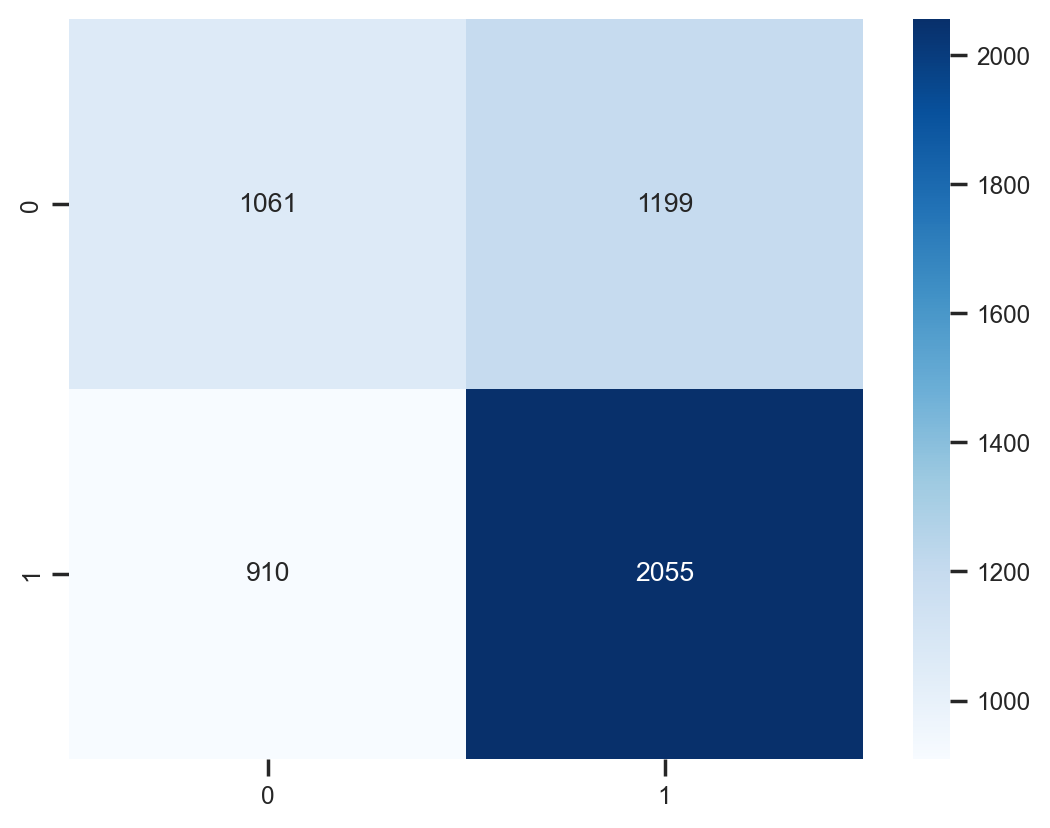

In [44]:
# Visualize the confusion matrix as a seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(data = cm, annot=True, cmap="Blues", fmt="d")
plt.show()

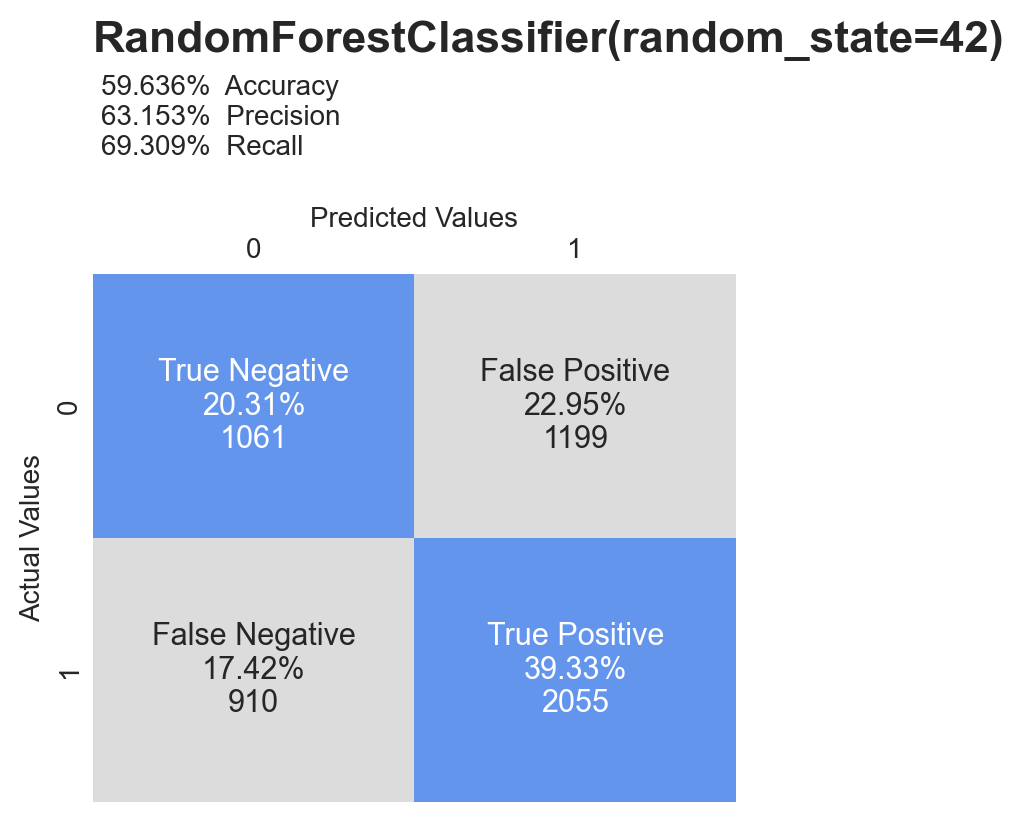

In [45]:
# Generate a better custom Confusion Matrix

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100

cm = confusion_matrix(y_test, y_pred)
# Normalize true, pred, or all
cm_norm = confusion_matrix(y_test, y_pred, normalize='all')
cm_colors = sns.color_palette(['gainsboro', 'cornflowerblue'])

# axis labels for the confusion matrix plot
cm_y_labels = ['0','1'] # column labels
cm_x_labels = ['0','1'] # row labels

# Confusion matrix labels
# Review and update to match the appropriate labels for your data set
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm_norm.flatten()]
group_labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names, group_percentages, group_counts)]
group_labels = np.asarray(group_labels).reshape(2,2)

# Begin plot setup
fig, ax = plt.subplots(figsize=(4.2, 4.2))

# Heatmap
sns.heatmap(np.eye(2), annot=group_labels, annot_kws={'size': 11}, fmt='',
            cmap=cm_colors, cbar=False,
            yticklabels=cm_y_labels, xticklabels=cm_x_labels, ax=ax)

# Axis elements
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=10, length=0)
ax.set_xlabel('Predicted Values', size=10)
ax.set_ylabel('Actual Values', size=10)

# Position group labels and set colors
for text_elt, group_label in zip(ax.texts, group_labels):
    ax.text(*text_elt.get_position(), '\n', color=text_elt.get_color(),
            ha='center', va='top')

# Title for each plot
# Adjust pad to provide room for the score report below title and above confusion matrix plot
plt.title(f'{model}', pad=80, loc='left', fontsize=16, fontweight='bold')

# Score reports beneath each title
# Adjust x and y to fit report
plt.figtext(0.21, 0.81, f'{accuracy:.3f}%  Accuracy\n{precision:.3f}%  Precision\n{recall:.3f}%  Recall', wrap=True, ha='left', fontsize=10)

# Disply the plot!
plt.tight_layout()
plt.subplots_adjust(left=0.2)
print('\n') # Add a blank line for improved spacing
plt.show()